In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [128]:
heart_df = pd.read_csv('1_ML_Datas/heart-disease.csv')
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [129]:
x = heart_df.drop('target', axis=1)
y = heart_df['target']

In [174]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [28]:
clf.score(X_test, y_test)

0.8524590163934426

In [29]:
y_pred = clf.predict(X_test)

**HyperParameter Tuning by Hand**
* `max_depth`
* `max_features`
* `min_samples_leaf`
* `min_sample_split`
* `n_estimators`

In [30]:
def evaluation_preds(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    return metric_dict

**Splitting the data in train, test, and validation for hyper tuning parameters (70-80% for training, 10-15% for validation, and 10-15% for testing**

In [31]:
#Shuffle data using pandas smaple function
heart_disease = heart_df.sample(frac=1)

In [32]:
#Split into x and y
np.random.seed(42)
x = heart_disease.drop('target', axis=1)
y = heart_disease['target']

#Splitting the data in train, validation and test sets
train_split = round(0.7*len(heart_disease)) #70% of data
valid_split = round(train_split+0.15*len(heart_disease)) #15% of data
X_train, y_train = x[:train_split], y[:train_split]
X_valid, y_valid = x[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = x[valid_split:], y[valid_split:]
len(X_train), len(X_valid), len(X_test)

(212, 45, 46)

In [33]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

#Make Predictions
y_pred = clf.predict(X_valid)

In [34]:
#Evaluate the classifier on validation set
baseline_matrics = evaluation_preds(y_valid, y_pred)

Accuracy: 86.67%
Precision: 0.76
Recall: 1.00
F1 Score: 0.86


**HyperTuning Parameter 1**

In [35]:
np.random.seed(42)
clf_2 = RandomForestClassifier(n_estimators=200,
                              max_depth=8)
clf_2.fit(X_train, y_train)
#Make prediction
y_pred_2 = clf_2.predict(X_valid)

#Evaluating model
clf_2_metrics = evaluation_preds(y_valid, y_pred_2)

Accuracy: 86.67%
Precision: 0.76
Recall: 1.00
F1 Score: 0.86


**Hyperparameter tuning with RandomizedSearchCV**

In [56]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
grids = {'n_estimators':randint(10, 1000),
         'bootstrap':[True, False],
         'max_depth':randint(2, 50),
         'max_features':['sqrt', 'log2'],
         'min_samples_split':randint(2, 20),
         'min_samples_leaf':randint(2, 30),
         'criterion':['gini', 'entropy']}

In [64]:
#Split into X and Y
np.random.seed(42)
x = heart_disease.drop('target', axis=1)
y = heart_disease.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier(n_jobs=-1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf, 
                            param_distributions=grids,
                            n_iter = 20, #number of models to try-number of iteration
                            cv=5,
                            verbose=3,
                            n_jobs=-1)

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [65]:
# Finding best parameters
rs_clf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 16,
 'max_features': 'log2',
 'min_samples_leaf': 12,
 'min_samples_split': 6,
 'n_estimators': 273}

In [79]:
# Make prediction with the best parameters
y_rs_pred = rs_clf.predict(X_test)

# Evaluate predictions
rs_result = evaluation_preds(y_test, y_rs_pred)

Accuracy: 81.97%
Precision: 0.81
Recall: 0.84
F1 Score: 0.83


**Hyperparameter Tuning with GridSearchCV**

In [74]:
grid_2 = {
    'n_estimators':[200, 273, 345, 410],
    'max_depth':[None, 16, 23],
    'min_samples_split':[6, 12],
    'min_samples_leaf':[3, 12],
    'max_features':['sqrt', 'log2']
}

In [167]:
from sklearn.model_selection import GridSearchCV, train_test_split
np.random.seed(42)
x = heart_disease.drop('target', axis=1)
y = heart_disease.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Instantiate RandomForestClassifier
clf = RandomForestClassifier()

# Setup GridSearchCV
grid_clf = GridSearchCV(estimator=clf,
                        param_grid=grid_2,
                        cv=5,
                        verbose=2)

# Fit the GridSearchCV version of clf
grid_clf.fit(X_train, y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=273; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=273; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=3, min_samples_split=6,

In [168]:
# Finding best parameters
grid_clf.best_params_

{'max_depth': 16,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 273}

In [169]:
# Making predictions
y_grid_pred = grid_clf.predict(X_test)

In [170]:
# Evaluating the model
grid_result = evaluation_preds(y_test, y_grid_pred)

Accuracy: 85.25%
Precision: 0.84
Recall: 0.87
F1 Score: 0.86


**Comparing different model metrics**

In [171]:
compare_metrics = pd.DataFrame({
    "Baseline":baseline_matrics,
    "clf_2":clf_2_metrics,
    "random_search":rs_result,
    "grid_search":grid_result
})
compare_metrics

,Baseline,clf_2,random_search,grid_search
accuracy,0.87,0.87,0.82,0.85
precision,0.76,0.76,0.81,0.84
recall,1.00,1.00,0.84,0.87
f1,0.86,0.86,0.83,0.86


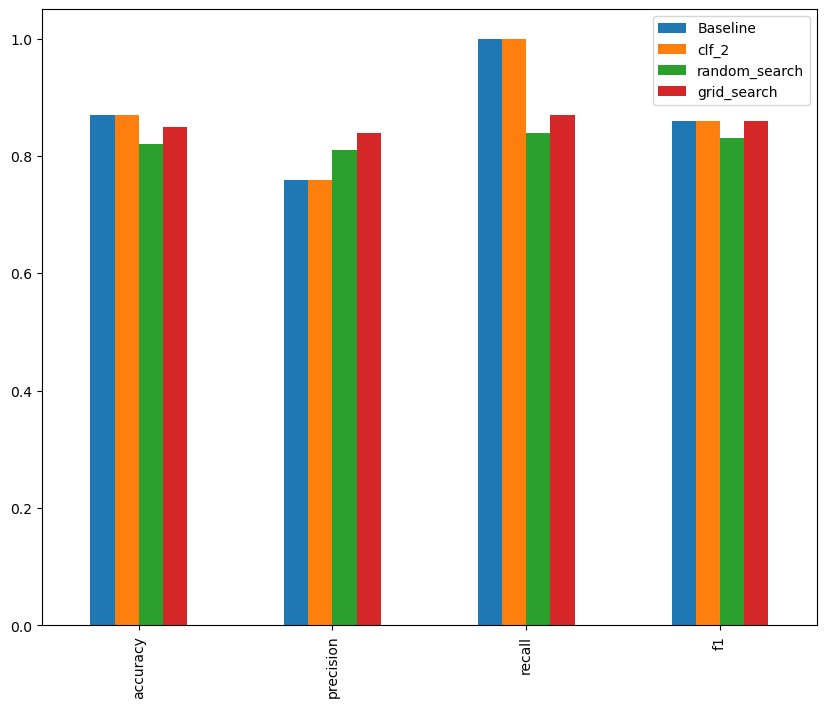

In [172]:
graph = compare_metrics.plot.bar(figsize=(10, 8));

In [95]:
fig = graph.get_figure()
fig.savefig('ML_Metric_comparison.jpg', dpi=1200)

**Feature Importances**

In [175]:
importance = clf.feature_importances_.tolist()
feature_names = clf.feature_names_in_.tolist()

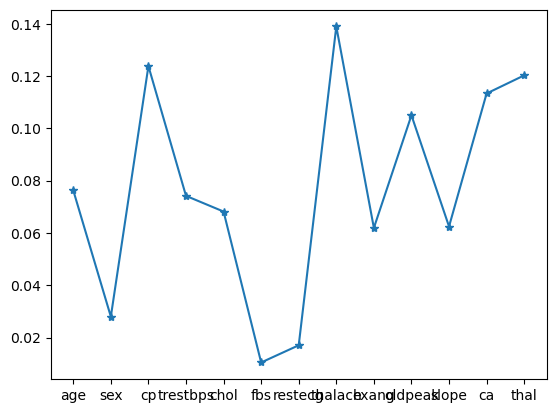

In [176]:
plt.plot(feature_names, importance, marker='*')

In [177]:
for name, importance in zip(feature_names, importance):
    print(f'{name}: {importance:.2f}')

age: 0.08
sex: 0.03
cp: 0.12
trestbps: 0.07
chol: 0.07
fbs: 0.01
restecg: 0.02
thalach: 0.14
exang: 0.06
oldpeak: 0.11
slope: 0.06
ca: 0.11
thal: 0.12


**Save and Load Machine Learning Model**
* Python's `pickle` module
* `joblib` module

Using Pickle Module

In [192]:
import pickle

#Saving Model
pickle.dump(grid_clf, open('classification_ML.pkl', 'wb'))

In [195]:
#Loading Model
pickle_load = pickle.load(open('classification_ML.pkl', 'rb'))

In [197]:
#Evaluating the model
y_pred_pickle = pickle_load.predict(X_test)
evaluation_preds(y_test, y_pred_pickle)

Accuracy: 85.25%
Precision: 0.84
Recall: 0.87
F1 Score: 0.86


{'accuracy': 0.85, 'precision': 0.84, 'recall': 0.87, 'f1': 0.86}

Using Joblib Module

In [198]:
from joblib import dump, load

#Saving Model
dump(rs_clf, filename='classification_ML.joblib')

['classification_ML.joblib']

In [199]:
#Loading saved model
joblib_load = load('classification_ML.joblib')

In [200]:
#Evaluating model
y_pred_joblib = joblib_load.predict(X_test)
evaluation_preds(y_test, y_pred_joblib)

Accuracy: 81.97%
Precision: 0.81
Recall: 0.84
F1 Score: 0.83


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.84, 'f1': 0.83}